# Intro to SMuRF
The SMuRF software consists of a server and client.  The server and client are started in docker containers.  The SMuRF server provides and EPICS channel access interface to access PVs (registers, and higher level controls) and acquires the streaming data.  It can perform filtering/downsampling for CMB applications.



## Server startup

In a separate terminal we'll start the server with:
```bash
cd /home/cryo/docker/smurf/dev_sw/slotN/v4.2.1
./run.sh -N 5; docker logs -f smurf_server_s5
```
-N 5 specifies slot 2 and EPICS server prefix smurf_server_s5

A GUI will pop up that we can use to interrogate the FPGA registers


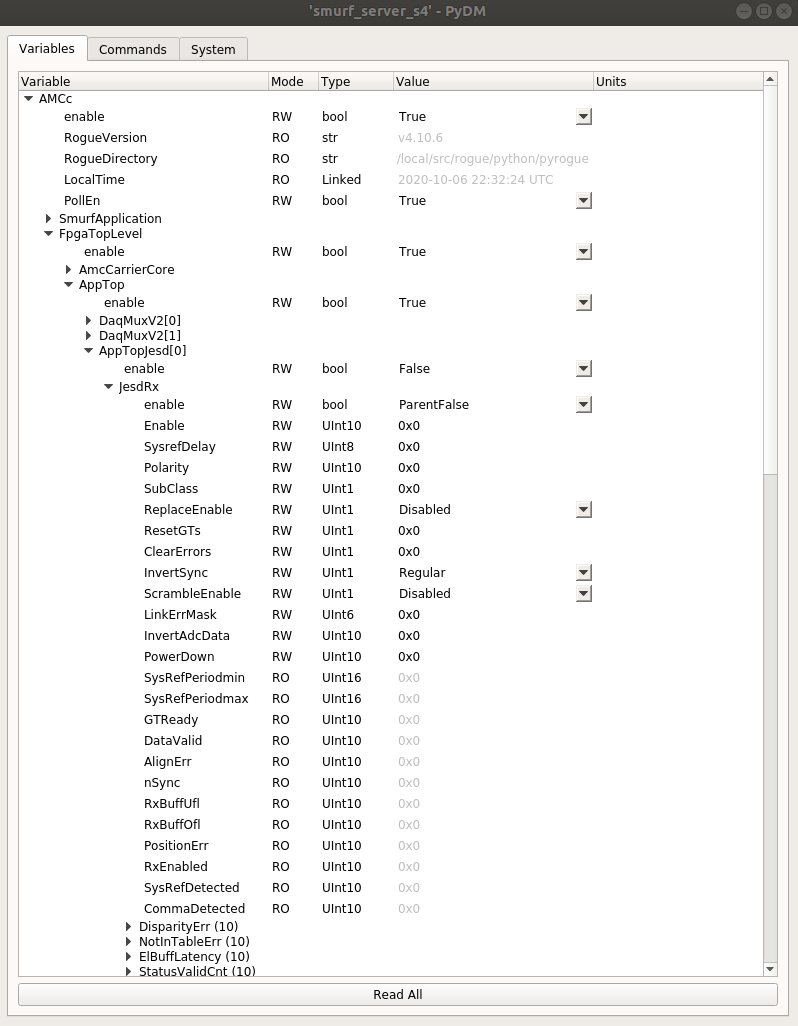

## PySMuRF Setup

PySMuRF is the client side control.  It communicates with the server via EPICS channel access (CA).  First we start the server and do imports

In [1]:
import pysmurf.client
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import epics
import os

%matplotlib inline

Next we'll define the EPICS server prefix and experiment configuration file

In [2]:
epics_prefix = "smurf_server_s2"
config_file  = "/usr/local/src/pysmurf/cfg_files/stanford/experiment_fp31_cc03-02_lbOnlyBay0.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix, cfg_file=config_file, setup=False, make_logfile=True)

Next we run a setup command.  This will initialize the FPGA and load the configuration defined in config_file.

In [3]:
S.setup()

False

### Acquiring data from the digitzers

Let's look at the ADC data.  We'll see the LO and it's image:


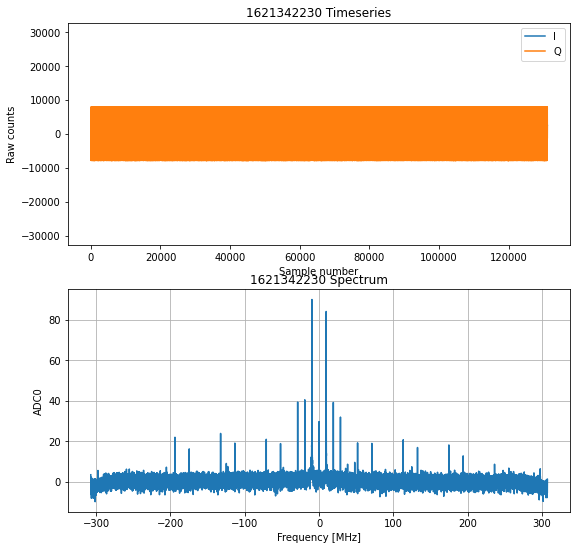

In [4]:
adc_data = S.read_adc_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

### Null the LO
Next let's null the LO with the RTM DACs


In [13]:
## Minimizaiton IQ cal
import epics
from scipy.optimize import minimize

lo_offset = -9.6

def getResp(band, channel):
    S.set_eta_mag_scaled_channel(band, channel, 1)
    S.set_eta_phase_degree_channel(band, channel, 0)
    resp = S.get_frequency_error_mhz(band, channel)
    S.set_eta_phase_degree_channel(band, channel, 90)
    resp = resp + 1j*S.get_frequency_error_mhz(band, channel)
    return resp


def updateCal(x):
    S.set_rtm_slow_dac_volt(1, x[0])
    S.set_rtm_slow_dac_volt(2, x[1])
    return np.abs(getResp(0, dac_cal_ch))**2


S.set_cpld_reset(0)

S.set_rtm_slow_dac_enable(1, 2)
S.set_rtm_slow_dac_enable(2, 2)

# process all channels (even with no amplitude)
epics.caput(epics_prefix + ':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:highCurrentMode', 1)

# which channel to null
freqs = epics.caget(epics_prefix+':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:toneFrequencyOffsetMHz')
dac_cal_ch = np.argmin(np.abs(freqs + lo_offset))

S.set_center_frequency_mhz_channel(0, dac_cal_ch, 0)
S.set_amplitude_scale_channel(0, dac_cal_ch, 0)
S.set_feedback_enable_channel(0, dac_cal_ch, 0)

 
x0 = (0, 0)
bnds = ((-10, 10), (-10, 10))
res = minimize(updateCal, x0, method='Powell', bounds=bnds, tol=1e-6)
print(f'IQ DAC cal is: ' + str(res.x))
updateCal(res.x)

IQ DAC cal is: [0.65986467 3.39356188]


3.024167131115973e-07

In [14]:
np.abs(getResp(0, dac_cal_ch))**2

6.898079163875079e-08

### Null the LO
Next let's look at the nulled LO


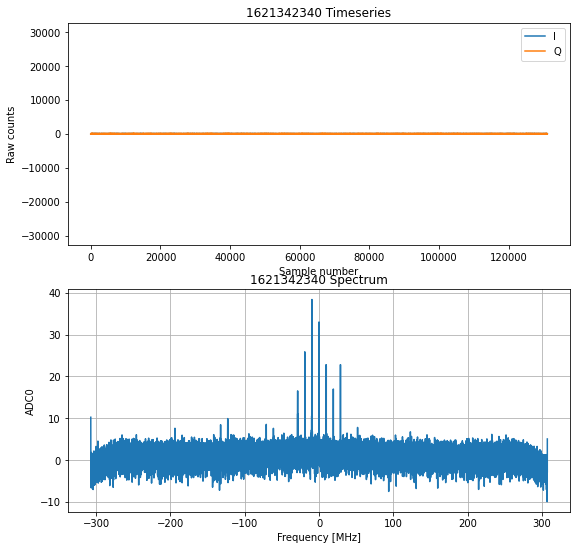

In [18]:
adc_data = S.read_adc_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

### Play a single tone
Let's play a single tone and look at DAC and ADC

In [19]:
S.set_amplitude_scale_channel(0, 2, 12)

/usr/local/src/pysmurf/python/pysmurf/client/util/smurf_util.py:1723: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(f_plot, 10*np.log10(p_dac))


(-20.0, 90.0)

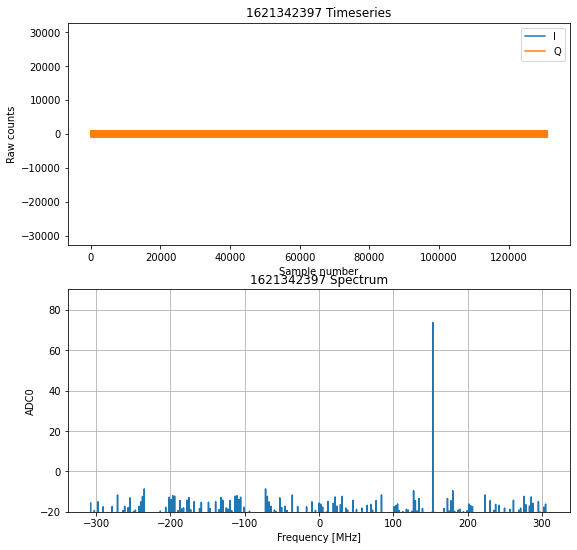

In [22]:
dac_data = S.read_dac_data(data_length=2**16, band=0, make_plot=True, show_plot=True)
plt.ylim([-20, 90])

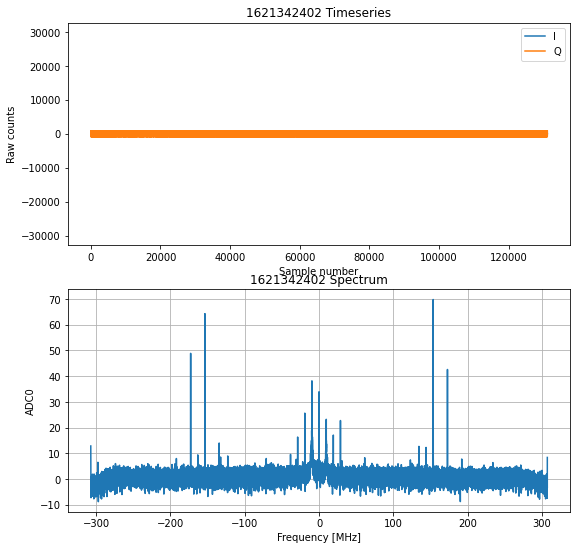

In [23]:
adc_data = S.read_adc_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

We can see the x4 Rx tones -- main tone, upmix image, downmix image x2.  Let's null the upmix image

In [91]:
freqs = epics.caget(epics_prefix+':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:toneFrequencyOffsetMHz')
j = 2
main_channel = j
channel      = np.argmin(np.abs(freqs + freqs[j] + 2*9.6))
readback_channel = channel
#channel      = np.argmin(np.abs(freqs + freqs[j]))
#readback_channel = np.argmin(np.abs(freqs + freqs[j]))
epics.caput(epics_prefix + f':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:iqSynthesisCorrection:channelIndex[{channel}]', main_channel)
S.set_amplitude_scale_channel(0, main_channel, 14)
         
def updateCal(x):
    iCorrection = epics_prefix + f':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:iqSynthesisCorrection:iCorrection[{channel}]'
    qCorrection = epics_prefix + f':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:iqSynthesisCorrection:qCorrection[{channel}]'
    epics.caput(iCorrection, np.round(x[0]*2**15))
    epics.caput(qCorrection, np.round(x[1]*2**15))
    return np.abs(getResp(0, readback_channel))**2
x0 = (0, 0)
bnds = ((-0.3, 0.3), (-0.3, 0.3))
res = minimize(updateCal, x0, method='Powell', bounds=bnds, tol=1e-6)
print(f'Channel {main_channel} cal is: ' + str(res.x))
updateCal(res.x)

Channel 2 cal is: [ 0.18410951 -0.07683613]


5.160522505320841e-08

In [93]:
channel

29

In [115]:
S.set_amplitude_scale_channel(0, 0, 0)
S.set_center_frequency_mhz_channel(0, 0, 0)

In [141]:
for i in range(16, 24):
    epics.caput(epics_prefix + f':AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:iqSynthesisCorrection:channelIndex[{i}]', 0)


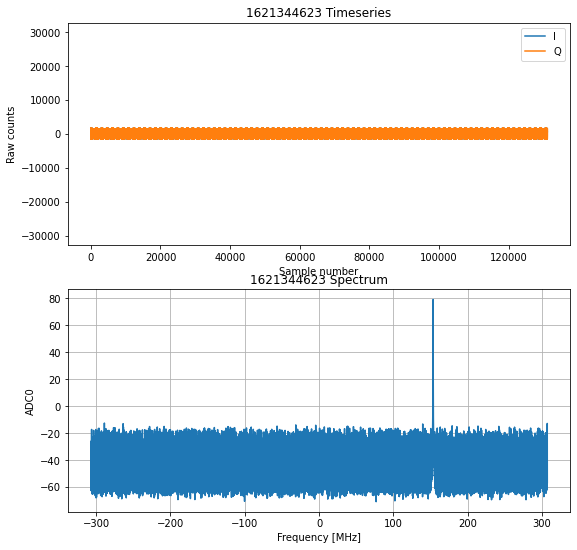

In [142]:
dac_data = S.read_dac_data(data_length=2**16, band=0, make_plot=True, show_plot=True)

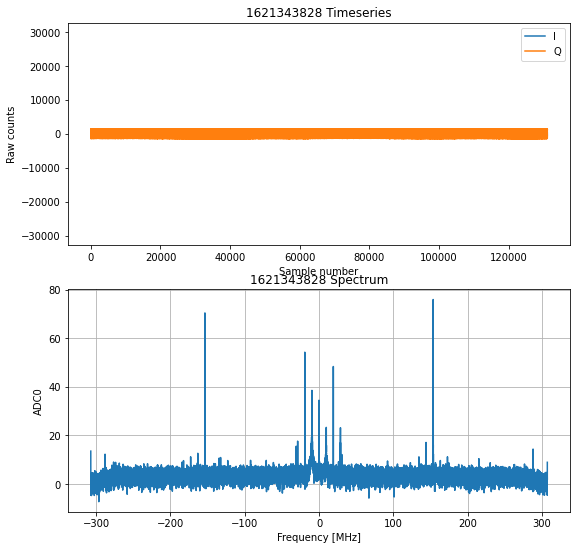

In [102]:
adc_data = S.read_adc_data(data_length=2**16, band=0, make_plot=True, show_plot=True)